In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import seaborn as sns
import librosa
import librosa.display
import IPython


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm


In [2]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'

In [3]:
crema = []
for wav in sorted(os.listdir(Crema_Path)):
    emotion = wav.partition(".wav")[0].split('_')
    if emotion[2] == 'SAD':
        crema.append((emotion[0], 'sad', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'ANG':
        crema.append((emotion[0], 'angry', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'DIS':
        crema.append((emotion[0], 'disgust', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'FEA':
        crema.append((emotion[0], 'fear', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'HAP':
        crema.append((emotion[0], 'happy', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    elif emotion[2] == 'NEU':
        crema.append((emotion[0], 'neutral', Crema_Path+'/'+wav, emotion[1], emotion[3]))
    else:
        crema.append((emotion[0], 'unknown', Crema_Path+'/'+wav, emotion[1], emotion[3]))

df = pd.DataFrame.from_records(crema, columns=['Person', 'Emotion', 'File_Path', 'sentence','intensity'])
df.head()


,Person,Emotion,File_Path,sentence,intensity
0,1001,angry,../input/speech-emotion-recognition-en/Crema//...,DFA,XX
1,1001,disgust,../input/speech-emotion-recognition-en/Crema//...,DFA,XX
2,1001,fear,../input/speech-emotion-recognition-en/Crema//...,DFA,XX
3,1001,happy,../input/speech-emotion-recognition-en/Crema//...,DFA,XX
4,1001,neutral,../input/speech-emotion-recognition-en/Crema//...,DFA,XX


In [4]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder 
encoder = LabelEncoder()
# Fit the encoder on the column and transform the values
df['Emotion_encoded'] = encoder.fit_transform(df['Emotion'])

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
label_mapping

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

In [6]:
df.groupby('Emotion')['intensity'].count()


Emotion
angry      1271
disgust    1271
fear       1271
happy      1271
neutral    1087
sad        1271
Name: intensity, dtype: int64

In [7]:
df['Emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [8]:
def wave_plot(data,sr,emotion):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr)

In [9]:
emotion_names=df['Emotion'].unique()

# Plotting and listening to a sample of each Emotion


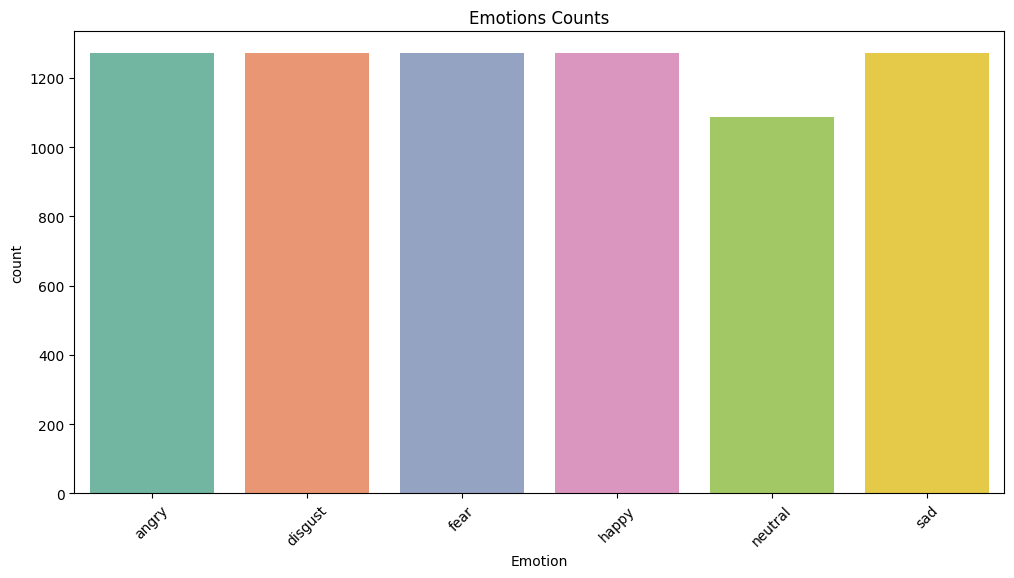

In [10]:
import seaborn as sns
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

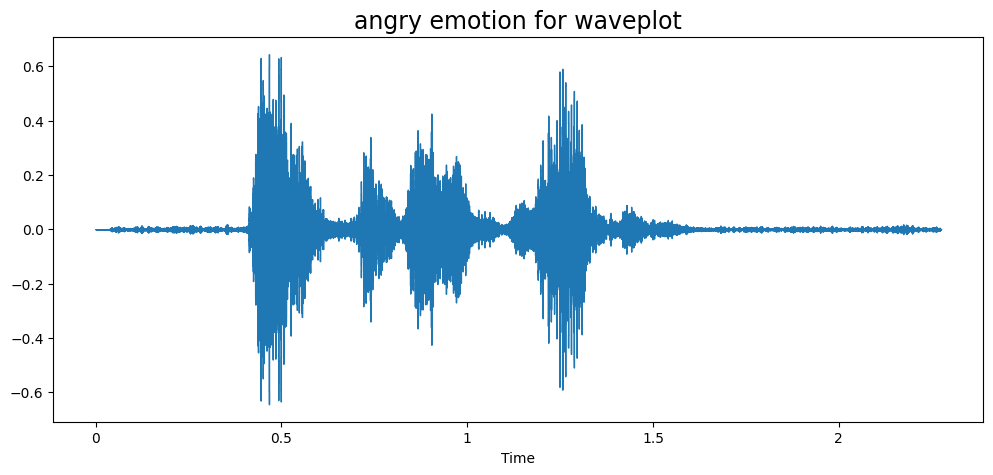

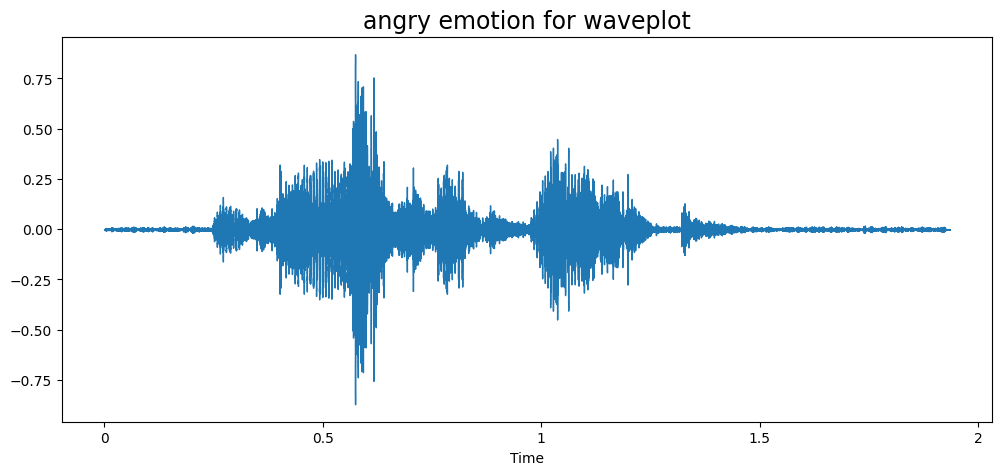

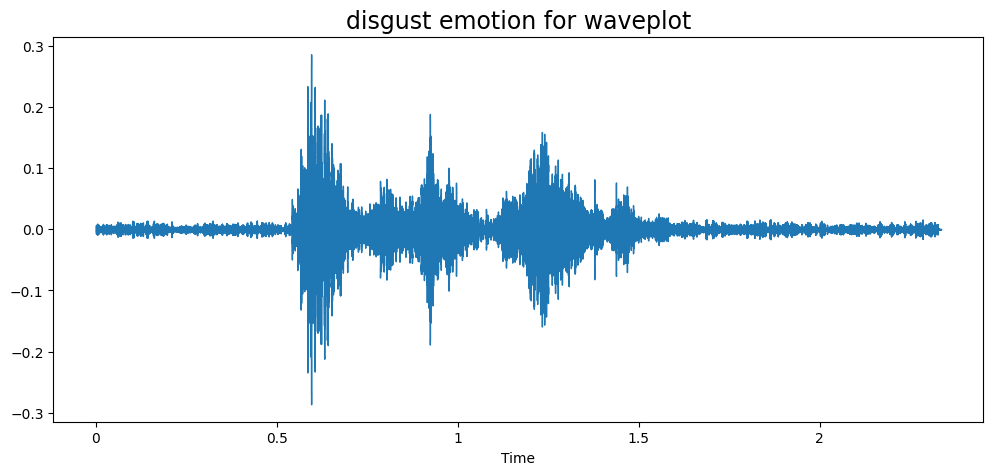

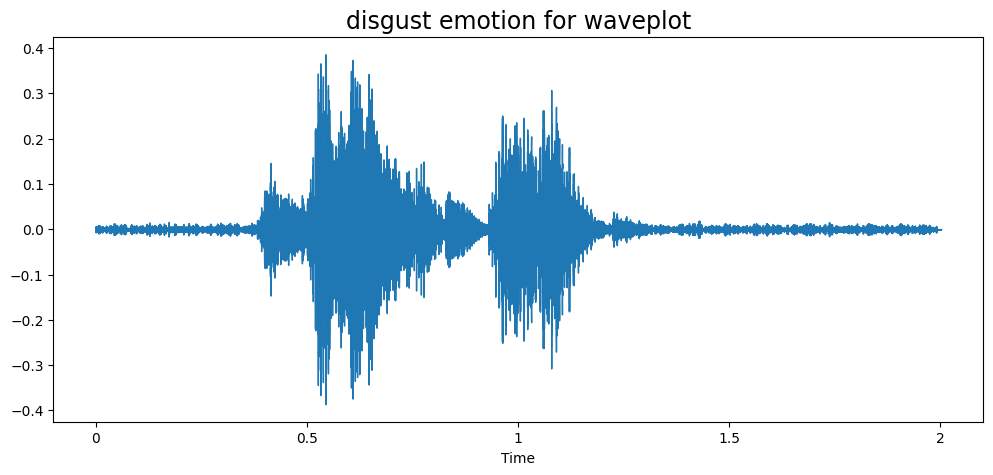

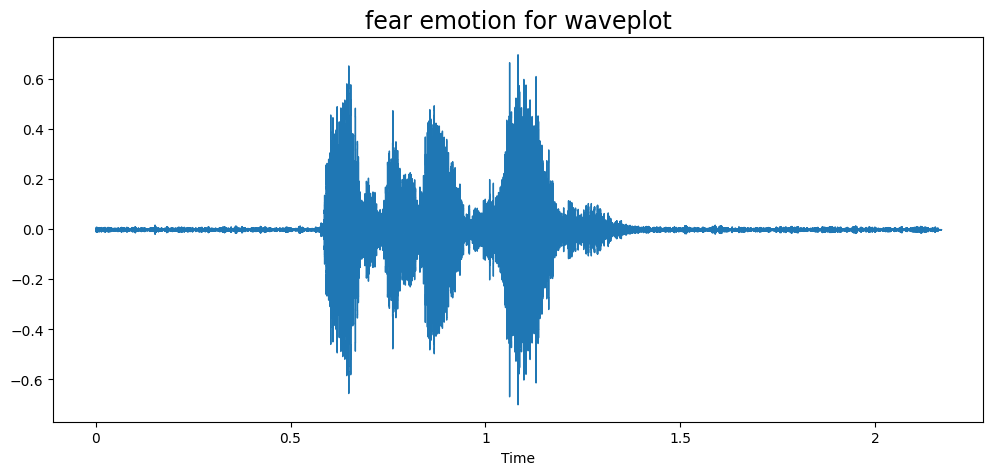

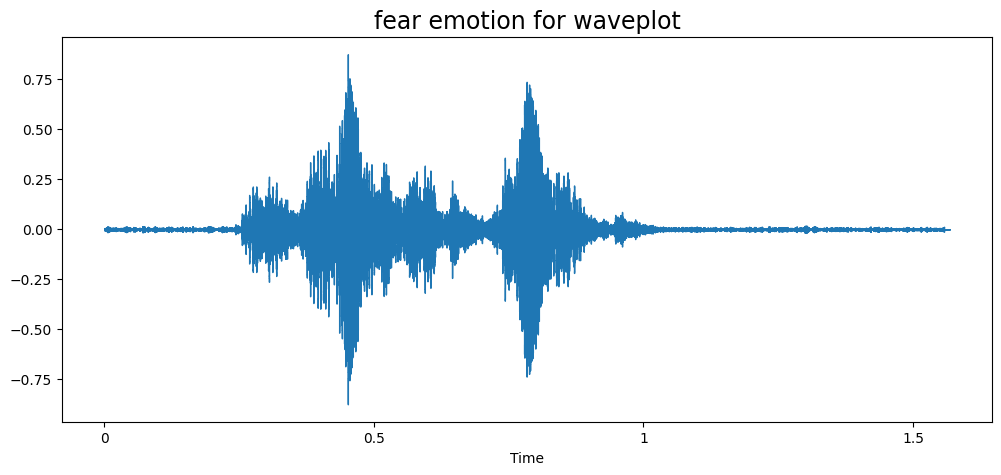

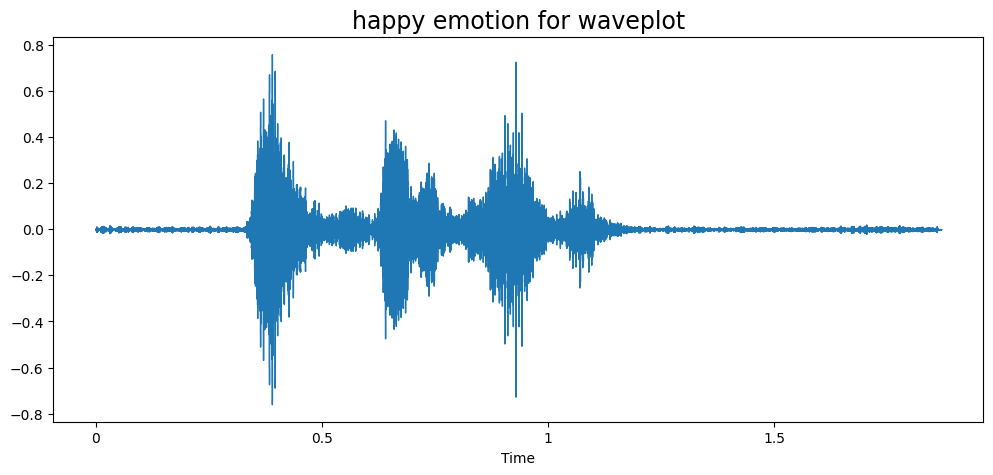

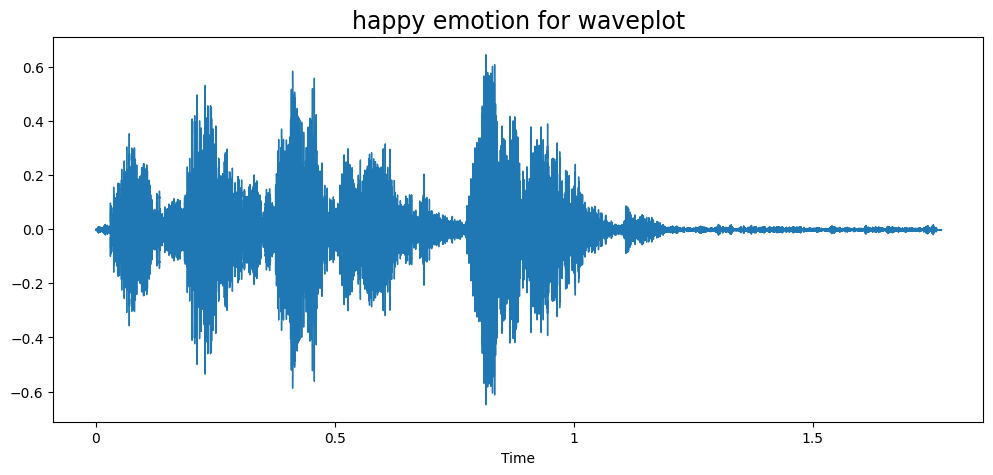

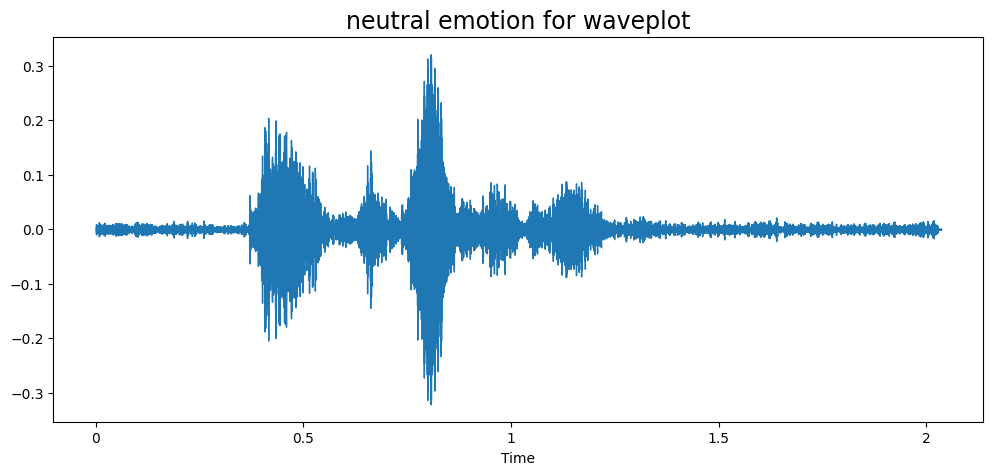

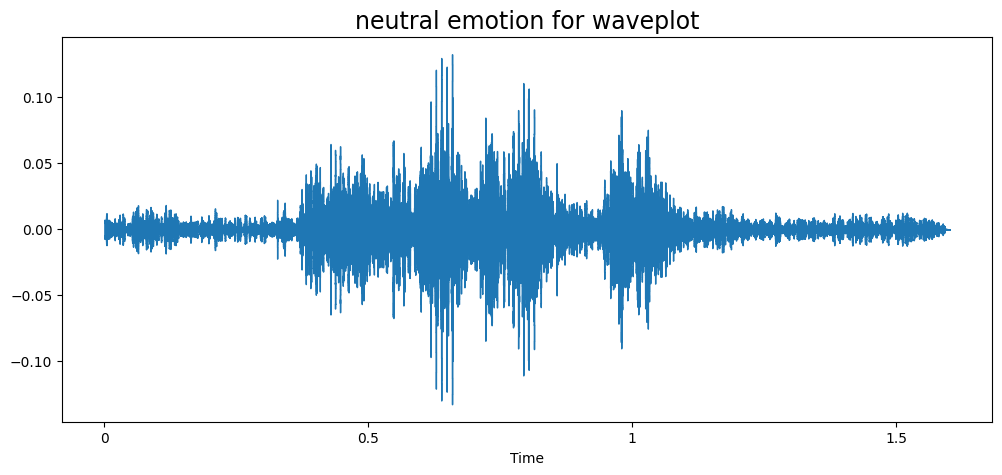

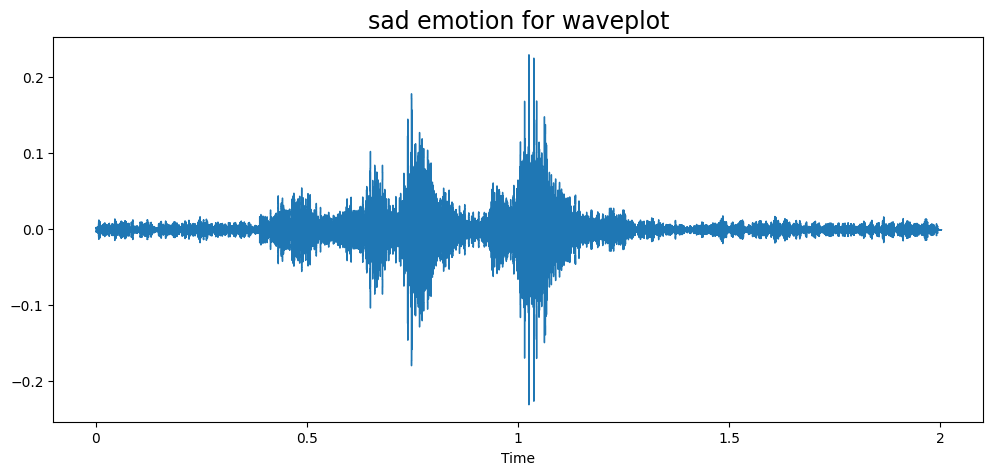

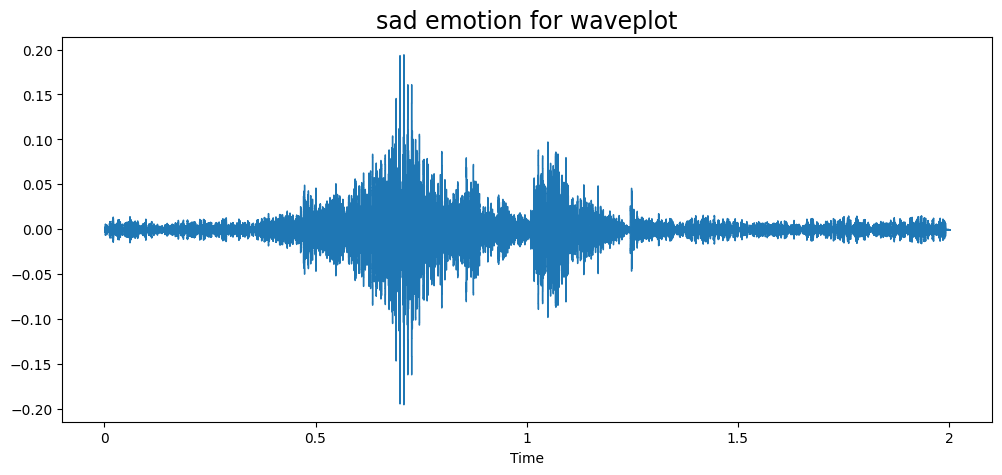

In [11]:
audio_path=[]
for emotion in emotion_names:
    paths=np.array(df['File_Path'][df['Emotion']==emotion])[:2]
    for path in paths:
        data,sr=librosa.load(path)
        wave_plot(data,sr,emotion)
        audio_path.append(path)

In [12]:
i = 0
for emotion in emotion_names:
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i]))
    print(f'{emotion} Audio Sample\n')
    IPython.display.display(IPython.display.Audio(audio_path[i+1]))
    i+=2

angry Audio Sample



angry Audio Sample



disgust Audio Sample



disgust Audio Sample



fear Audio Sample



fear Audio Sample



happy Audio Sample



happy Audio Sample



neutral Audio Sample



neutral Audio Sample



sad Audio Sample



sad Audio Sample



# Data analysis

**Choosing parameters for melspectogram**

For distinguishing between different emotional states in voice recordings (such as angry, sad, and happy), a suitable value for `n_fft` can vary depending on the specific characteristics of the audio data and the analysis requirements.

a value in the range of 1024 to 4096 is commonly used for speech-related analysis tasks.

**hop_length**

As for the specific value of hop_length, it's common to set it to a fraction of n_fft to achieve a good balance between time and frequency resolution. A typical choice is to set hop_length to half (hop_length = n_fft // 2) or a quarter (hop_length = n_fft // 4) of the n_fft value. In this case, a hop_length value of 512 (hop_length = 2048 // 4) is choosen.

In [13]:
def melspectogram_wave_plot(path,emotion):
    y,sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=265, n_fft=2048 ,hop_length=512)

    S_dB = librosa.power_to_db(S)
    
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title=f'Mel-frequency spectrogram for {emotion} sound')

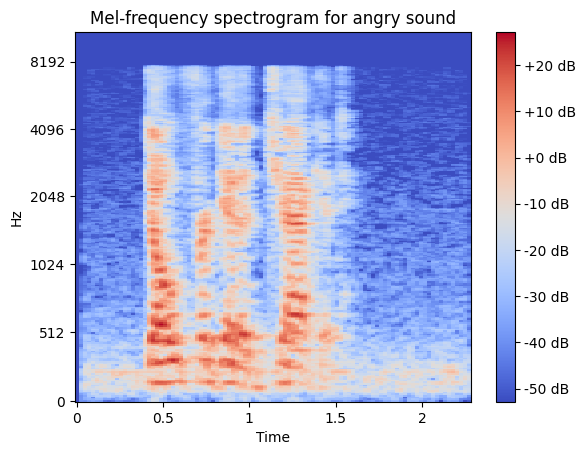

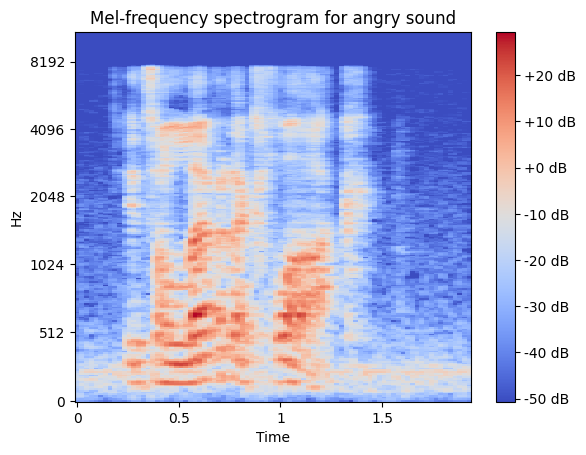

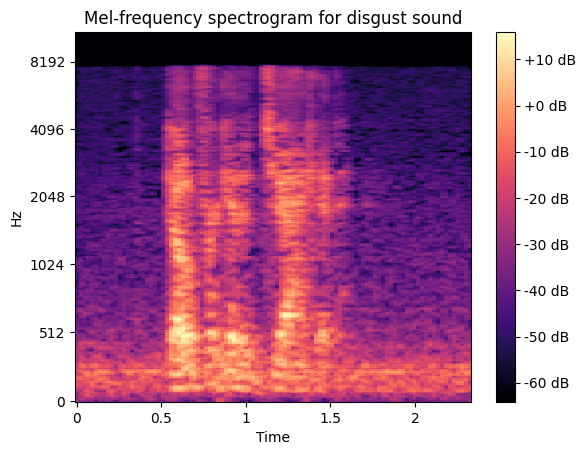

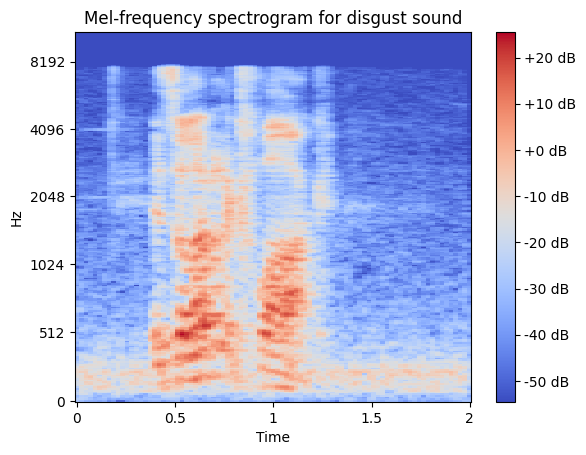

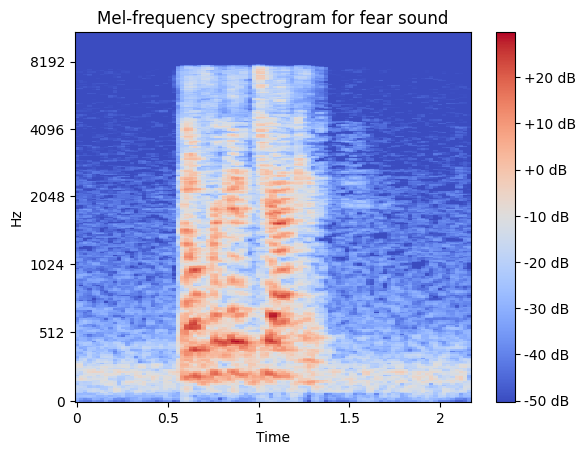

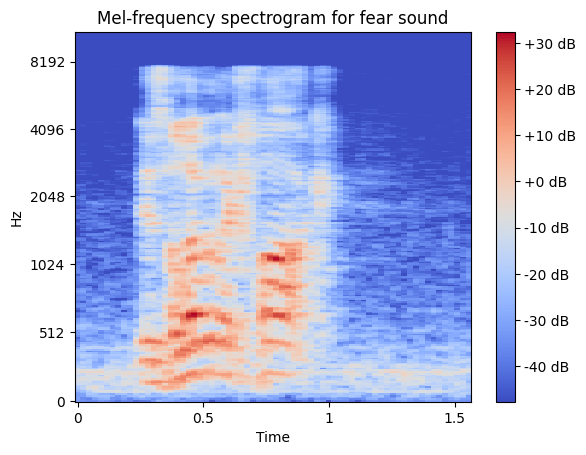

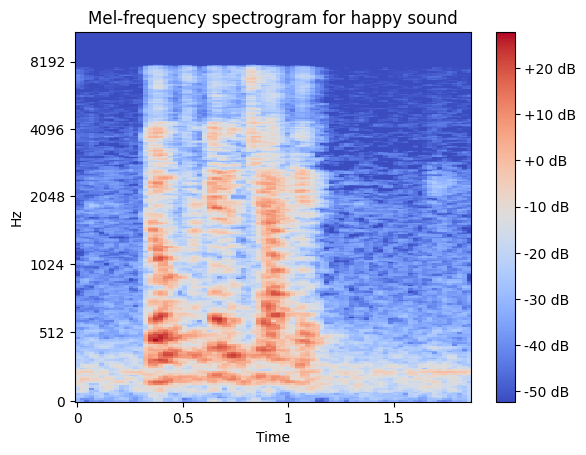

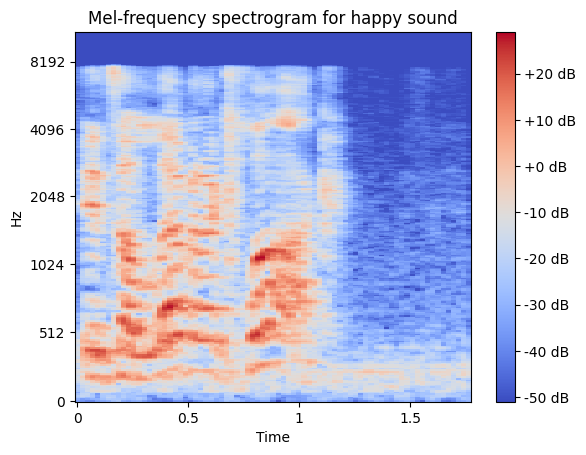

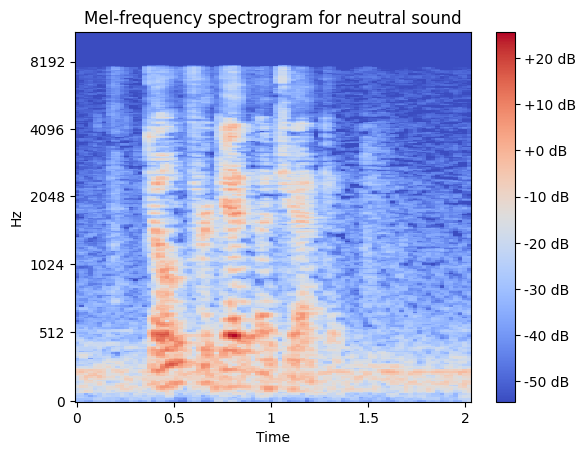

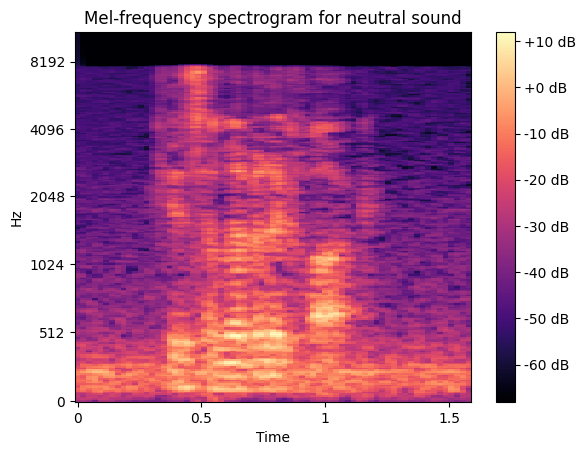

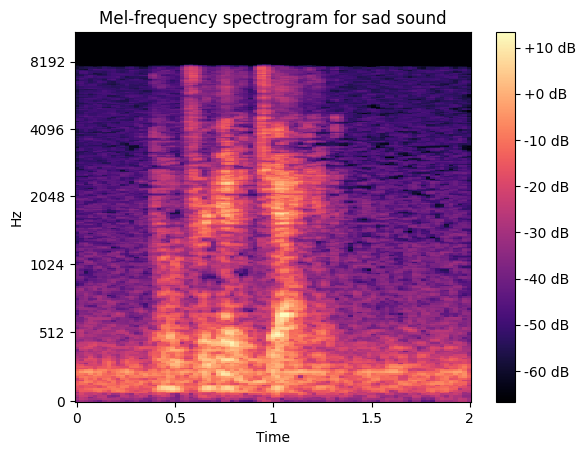

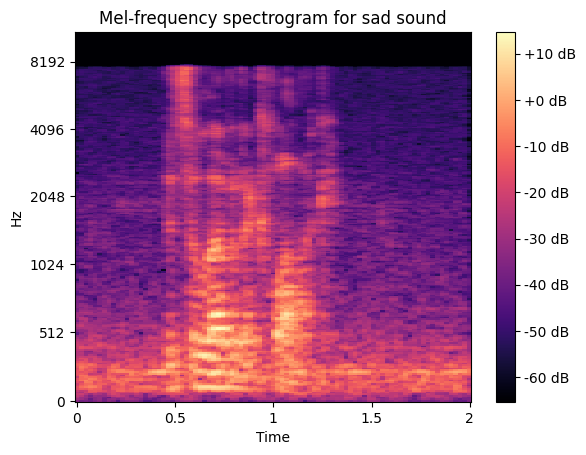

In [14]:
for idx in range(0, len(audio_path), 2):
    melspectogram_wave_plot(audio_path[idx],emotion_names[idx//2])
    melspectogram_wave_plot(audio_path[idx+1],emotion_names[idx//2])

In [15]:
!pip install torchaudio

In [10]:
import torchaudio
import torchaudio.transforms as transforms

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

0it [00:00, ?it/s]/tmp/ipykernel_32/2468677012.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
7442it [02:00, 61.66it/s]


In [11]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

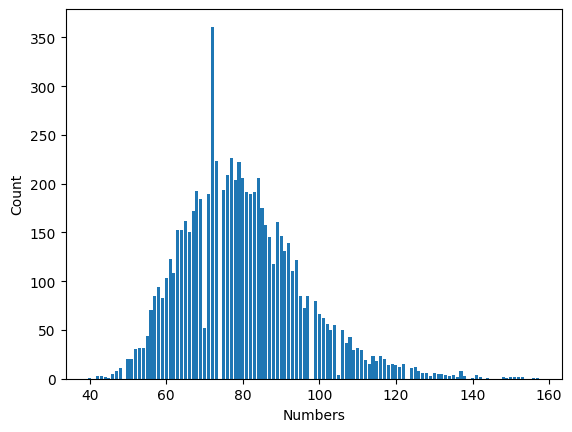

min is 40
max is 157


In [12]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')


In [13]:
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [14]:
data_2D.shape

(7442, 128, 160)

In [15]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)


In [16]:
normalized_data[1]

array([[0.56973195, 0.5444743 , 0.51813316, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5450095 , 0.5570548 , 0.541499  , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.512481  , 0.55639714, 0.592978  , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.4755556 , 0.472118  , 0.4689895 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4661117 , 0.45966327, 0.44934118, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.448575  , 0.45664725, 0.44868642, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [17]:
data=np.expand_dims(normalized_data, axis=1)

In [18]:
labels=df.Emotion_encoded.to_numpy()

In [19]:
labels.shape

(7442,)

In [20]:
data.shape

(7442, 1, 128, 160)

In [21]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train & validation, 30% test )
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

# Perform the train-validation split (5% test, 95% train)
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.05, stratify=y_trainAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 4948
Validation set size: 261
Test set size: 2233


In [22]:
X_train.shape

(4948, 1, 128, 160)

In [24]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels


In [25]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=8, shuffle=False)


# Architecture

In [80]:
#change nn.sequential to take dict to make more readable 

class ParaNet(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 256-->512--->256 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=128, # input feature (frequency) dim after maxpooling 128*110 -> 128*27 (Melspectorgram*time)
            nhead=32, # 16 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=1024, # 2 linear layers in each encoder block's feedforward network: dim 128-->512--->128
            dropout=0.4, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=6)

        
        
        self.dropout=nn.Dropout(p=0.3)
        self.relu=nn.ReLU()
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,128,160) --> (16,128,80) -> (32,32,20) -> (64,8,5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),  #(1,128,160) - > (16,128,160)
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size  #(16,128,160) - > (16,64,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(16,64,80) - > (32,64,80)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters #(32,64,80) - > (32,16,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),#(32,16,20) - > (64,16,20)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(64,16,20) - > (64,4,5)
            nn.Dropout(p=0.4),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,265,160) --> (32,128,80) -> (64,32,20) -> (128,8,5)
        self.conv2Dblock2 = nn.Sequential(
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=32, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),#(1,256,160) - > (32,256,160)
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size (32,265,160) - > (32,128,80)
            nn.Dropout(p=0.4), #randomly zero 40% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=32, 
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=5,
                stride=1,
                padding=2
                      ),#(32,128,55) - > (64,128,55)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters (64,128,55) - > (64,32,20)
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=64,
                out_channels=128, # expand output feature map volume's depth to 64
                kernel_size=7,
                stride=1,
                padding=3
                      ),#(64,32,20) - > (128,32,13)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),#(128,32,13) - > (128,8,5)
            nn.Dropout(p=0.4),
        )
        
        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 6 logits 
        
        # 64*8*5+128*8*5 == 7680 input features --> 6 output emotions 
        self.fc1_linear = nn.Linear(64*4*5 + 128*4*5 +128,num_emotions) 
        
        ### Softmax layer for the 6 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer 
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1) 

        
        x_maxpool = self.transformer_maxpool(x)
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        x = x_maxpool_reduced.permute(2,0,1) 
        transformer_output = self.transformer_encoder(x)
        transformer_embedding = torch.mean(transformer_output, dim=0)
        
        
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)
        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax                       


In [82]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = ParaNet(6).to(device)

# include input feature map dims in call to summary()
summary(model, input_size=(32, 1, 128, 160))


Layer (type:depth-idx)                        Output Shape              Param #
ParaNet                                       [32, 6]                   --
├─Sequential: 1-1                             [32, 64, 4, 5]            --
│    └─Conv2d: 2-1                            [32, 16, 128, 160]        160
│    └─BatchNorm2d: 2-2                       [32, 16, 128, 160]        32
│    └─ReLU: 2-3                              [32, 16, 128, 160]        --
│    └─MaxPool2d: 2-4                         [32, 16, 64, 80]          --
│    └─Dropout: 2-5                           [32, 16, 64, 80]          --
│    └─Conv2d: 2-6                            [32, 32, 64, 80]          4,640
│    └─BatchNorm2d: 2-7                       [32, 32, 64, 80]          64
│    └─ReLU: 2-8                              [32, 32, 64, 80]          --
│    └─MaxPool2d: 2-9                         [32, 32, 16, 20]          --
│    └─Dropout: 2-10                          [32, 32, 16, 20]          --
│    └─Conv2d: 2

In [84]:
import torch.optim as optim

EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNet(6).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=LEARNING_RATE, momentum=0.8)

In [85]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for train_input, train_label in tqdm(data_loader):
        train_label = train_label.to(device)
        train_input = train_input.to(device)

        optimizer.zero_grad()
        
        output_logits, output_softmax = model(train_input.float())
        predictions = torch.argmax(output_softmax,dim=1)
        total_predictions += train_label.size(0)
        
        correct_predictions += (predictions == train_label).sum().item()
        
        loss = loss_fn(output_logits, train_label)

        losses.append(loss.item())


        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy


In [86]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for val_input, val_label in data_loader:
            val_label = val_label.to(device)
            val_input = val_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(val_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += val_label.size(0)

            correct_predictions += (predictions == val_label).sum().item()

            loss = loss_fn(output_logits, val_label)

            losses.append(loss.item())
            
            



        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)
        

    return mean_loss, accuracy

In [87]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 20  # Number of epochs to wait for improvement

In [88]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 619/619 [00:12<00:00, 48.24it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.7404849903841588
Train Accuracy 0.3251818916734034
Val   loss 1.4662877537987449
Val   Acc 0.4061302681992337



100%|██████████| 619/619 [00:13<00:00, 47.05it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.5650037950768416
Train Accuracy 0.3841956345998383
Val   loss 1.4623186588287354
Val   Acc 0.3716475095785441



100%|██████████| 619/619 [00:12<00:00, 48.28it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.5048310227078268
Train Accuracy 0.3894502829426031
Val   loss 1.4153358340263367
Val   Acc 0.41762452107279696



100%|██████████| 619/619 [00:12<00:00, 48.38it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.4525308576269567
Train Accuracy 0.42178658043654
Val   loss 1.4034025054989439
Val   Acc 0.3946360153256705



100%|██████████| 619/619 [00:13<00:00, 47.17it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.4135563898356165
Train Accuracy 0.4381568310428456
Val   loss 1.3729103442394373
Val   Acc 0.45977011494252873



100%|██████████| 619/619 [00:12<00:00, 48.23it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.3867530957562473
Train Accuracy 0.43674211802748586
Val   loss 1.3319012287891272
Val   Acc 0.4559386973180077



100%|██████████| 619/619 [00:13<00:00, 46.94it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.3681788847981824
Train Accuracy 0.45675020210185935
Val   loss 1.364378515518073
Val   Acc 0.4367816091954023



100%|██████████| 619/619 [00:12<00:00, 48.30it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.3438411875957434
Train Accuracy 0.4525060630557801
Val   loss 1.308234529061751
Val   Acc 0.46360153256704983



100%|██████████| 619/619 [00:13<00:00, 47.46it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.3098205123848985
Train Accuracy 0.4686742118027486
Val   loss 1.2359507481257122
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:12<00:00, 48.04it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.2824189960475114
Train Accuracy 0.4937348423605497
Val   loss 1.2220270958813755
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:12<00:00, 48.34it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.256484770813358
Train Accuracy 0.5113177041228779
Val   loss 1.2146795735214695
Val   Acc 0.5057471264367817



100%|██████████| 619/619 [00:13<00:00, 46.95it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.2445668682143067
Train Accuracy 0.5078819725141471
Val   loss 1.2800550533063484
Val   Acc 0.4559386973180077



100%|██████████| 619/619 [00:12<00:00, 48.41it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.225209492281296
Train Accuracy 0.5175828617623283
Val   loss 1.2171355558164192
Val   Acc 0.5363984674329502



100%|██████████| 619/619 [00:13<00:00, 47.04it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.2179709137545263
Train Accuracy 0.5196038803556993
Val   loss 1.1906474485541836
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:12<00:00, 48.01it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.1932131637471557
Train Accuracy 0.5337510105092966
Val   loss 1.163683000839118
Val   Acc 0.5172413793103449



100%|██████████| 619/619 [00:12<00:00, 48.15it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1768329194558842
Train Accuracy 0.5347615198059822
Val   loss 1.16486410390247
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:13<00:00, 46.90it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.1856512568397553
Train Accuracy 0.5402182700080841
Val   loss 1.2363199627760686
Val   Acc 0.5019157088122606



100%|██████████| 619/619 [00:12<00:00, 49.03it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.158183127593532
Train Accuracy 0.5483023443815683
Val   loss 1.1697055661317073
Val   Acc 0.524904214559387



100%|██████████| 619/619 [00:13<00:00, 47.15it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.1542572043535204
Train Accuracy 0.5444624090541633
Val   loss 1.2004568965146036
Val   Acc 0.524904214559387



100%|██████████| 619/619 [00:12<00:00, 48.62it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.1425990607222372
Train Accuracy 0.5563864187550526
Val   loss 1.2594646775361262
Val   Acc 0.4444444444444444



100%|██████████| 619/619 [00:13<00:00, 46.86it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.1289114334856751
Train Accuracy 0.5489086499595797
Val   loss 1.1146336342349197
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:12<00:00, 48.20it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.123239628669711
Train Accuracy 0.5624494745351657
Val   loss 1.1049040447581897
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:12<00:00, 48.61it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.1085494425936162
Train Accuracy 0.5634599838318513
Val   loss 1.118986161369266
Val   Acc 0.5517241379310345



100%|██████████| 619/619 [00:13<00:00, 47.10it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.082316270071008
Train Accuracy 0.5814470493128536
Val   loss 1.1345886479724536
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:12<00:00, 48.46it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.0953309060298568
Train Accuracy 0.5735650767987065
Val   loss 1.12540685227423
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:13<00:00, 46.80it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.072477616766928
Train Accuracy 0.5826596604688763
Val   loss 1.1606192408186016
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:12<00:00, 48.40it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.0661757739564715
Train Accuracy 0.5907437348423605
Val   loss 1.098403811454773
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 48.36it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.048184012461556
Train Accuracy 0.595392077607114
Val   loss 1.094486600521839
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:13<00:00, 47.13it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 1.0320439895732336
Train Accuracy 0.6024656426839127
Val   loss 1.0631465017795563
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:12<00:00, 48.75it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.0198553853061936
Train Accuracy 0.6054971705739692
Val   loss 1.0778177958546262
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:13<00:00, 46.88it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 1.0272697709103586
Train Accuracy 0.6052950687146321
Val   loss 1.1268460714455806
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 48.48it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 1.0053524967156628
Train Accuracy 0.6018593371059013
Val   loss 1.149556683771538
Val   Acc 0.5325670498084292



100%|██████████| 619/619 [00:12<00:00, 48.21it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 1.0183205882355162
Train Accuracy 0.6044866612772838
Val   loss 1.150345462741274
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:13<00:00, 47.10it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 1.0001229256728548
Train Accuracy 0.6109539207760711
Val   loss 1.060084185817025
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:12<00:00, 48.60it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.976837942379742
Train Accuracy 0.6313662085691188
Val   loss 1.0919229767539285
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:13<00:00, 46.80it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.9920686096290009
Train Accuracy 0.6180274858528698
Val   loss 1.089275593107397
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 48.38it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9847209182521253
Train Accuracy 0.6186337914308812
Val   loss 1.088535928364956
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:13<00:00, 46.76it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9759776662066217
Train Accuracy 0.6265157639450283
Val   loss 1.0267683231469356
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:12<00:00, 48.27it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.9566795221245539
Train Accuracy 0.6325788197251415
Val   loss 1.1037767086968278
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:12<00:00, 48.32it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.9606945995656662
Train Accuracy 0.6281325788197252
Val   loss 1.0731040781194514
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:13<00:00, 46.90it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.9340591737353552
Train Accuracy 0.6418755052546483
Val   loss 1.0328145550959038
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 48.51it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.9428150201267496
Train Accuracy 0.6358124494745352
Val   loss 1.0957357413841016
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:13<00:00, 46.99it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.9239829340543423
Train Accuracy 0.6491511721907841
Val   loss 1.1027527704383389
Val   Acc 0.5632183908045977



100%|██████████| 619/619 [00:12<00:00, 48.52it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.9177707611118264
Train Accuracy 0.6449070331447049
Val   loss 1.062446617718899
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:12<00:00, 48.37it/s]


Epoch 45, Learning Rate: 0.0001
Epoch 45/500
----------
Train loss 0.9212456709059837
Train Accuracy 0.645109135004042
Val   loss 1.0697440288283608
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:13<00:00, 46.78it/s]


Epoch 46, Learning Rate: 0.0001
Epoch 46/500
----------
Train loss 0.8924876094731068
Train Accuracy 0.6568310428455941
Val   loss 1.0024638103716301
Val   Acc 0.6398467432950191



100%|██████████| 619/619 [00:12<00:00, 48.13it/s]


Epoch 47, Learning Rate: 0.0001
Epoch 47/500
----------
Train loss 0.9015978897571179
Train Accuracy 0.6499595796281326
Val   loss 1.0275011947660735
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:13<00:00, 47.04it/s]


Epoch 48, Learning Rate: 0.0001
Epoch 48/500
----------
Train loss 0.8892142707196113
Train Accuracy 0.6657235246564268
Val   loss 1.1032616938605453
Val   Acc 0.5593869731800766



100%|██████████| 619/619 [00:12<00:00, 48.48it/s]


Epoch 49, Learning Rate: 0.0001
Epoch 49/500
----------
Train loss 0.8943680768444388
Train Accuracy 0.6523848019401779
Val   loss 1.007856011390686
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:13<00:00, 47.13it/s]


Epoch 50, Learning Rate: 0.0001
Epoch 50/500
----------
Train loss 0.8931532745792715
Train Accuracy 0.6671382376717866
Val   loss 1.0291079120202498
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 48.31it/s]


Epoch 51, Learning Rate: 0.0001
Epoch 51/500
----------
Train loss 0.8696137546337479
Train Accuracy 0.6632983023443816
Val   loss 1.0487203579960447
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 47.86it/s]


Epoch 52, Learning Rate: 0.0001
Epoch 52/500
----------
Train loss 0.8669779019999003
Train Accuracy 0.6715844785772029
Val   loss 1.0329756809003425
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:13<00:00, 46.87it/s]


Epoch 53, Learning Rate: 0.0001
Epoch 53/500
----------
Train loss 0.8706490388064855
Train Accuracy 0.6691592562651576
Val   loss 1.0614772348692922
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 48.30it/s]


Epoch 54, Learning Rate: 0.0001
Epoch 54/500
----------
Train loss 0.8531723362130379
Train Accuracy 0.6788601455133387
Val   loss 1.0298467567472747
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:13<00:00, 47.24it/s]


Epoch 55, Learning Rate: 0.0001
Epoch 55/500
----------
Train loss 0.8534705172110837
Train Accuracy 0.6784559417946645
Val   loss 0.9975803819569674
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:12<00:00, 48.14it/s]


Epoch 56, Learning Rate: 0.0001
Epoch 56/500
----------
Train loss 0.8370747503874183
Train Accuracy 0.6681487469684722
Val   loss 1.0564747073433616
Val   Acc 0.578544061302682



100%|██████████| 619/619 [00:12<00:00, 48.51it/s]


Epoch 57, Learning Rate: 0.0001
Epoch 57/500
----------
Train loss 0.8290609340145823
Train Accuracy 0.6871463217461601
Val   loss 0.998454314289671
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:13<00:00, 47.04it/s]


Epoch 58, Learning Rate: 0.0001
Epoch 58/500
----------
Train loss 0.815203689074863
Train Accuracy 0.6887631366208569
Val   loss 1.122144389333147
Val   Acc 0.5555555555555556



100%|██████████| 619/619 [00:12<00:00, 48.23it/s]


Epoch 59, Learning Rate: 0.0001
Epoch 59/500
----------
Train loss 0.8252047683820971
Train Accuracy 0.6875505254648343
Val   loss 1.0737475942481647
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:13<00:00, 47.17it/s]


Epoch 60, Learning Rate: 0.0001
Epoch 60/500
----------
Train loss 0.8019540354922438
Train Accuracy 0.6936135812449474
Val   loss 1.037017381552494
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:13<00:00, 47.43it/s]


Epoch 61, Learning Rate: 0.0001
Epoch 61/500
----------
Train loss 0.8066304763703817
Train Accuracy 0.6936135812449474
Val   loss 1.090184408606905
Val   Acc 0.5402298850574713



100%|██████████| 619/619 [00:12<00:00, 47.99it/s]


Epoch 62, Learning Rate: 0.0001
Epoch 62/500
----------
Train loss 0.7903606433042224
Train Accuracy 0.6986661277283751
Val   loss 1.0301346255071235
Val   Acc 0.5708812260536399



100%|██████████| 619/619 [00:12<00:00, 48.08it/s]


Epoch 63, Learning Rate: 0.0001
Epoch 63/500
----------
Train loss 0.8059688394164037
Train Accuracy 0.6863379143088116
Val   loss 1.0159456458958713
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:12<00:00, 48.29it/s]


Epoch 64, Learning Rate: 0.0001
Epoch 64/500
----------
Train loss 0.7970769673056287
Train Accuracy 0.6936135812449474
Val   loss 1.0712189078330994
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:13<00:00, 46.77it/s]


Epoch 65, Learning Rate: 0.0001
Epoch 65/500
----------
Train loss 0.7831235681698088
Train Accuracy 0.7039207760711399
Val   loss 0.9826430461623452
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:12<00:00, 47.82it/s]


Epoch 66, Learning Rate: 0.0001
Epoch 66/500
----------
Train loss 0.7740349980712129
Train Accuracy 0.7018997574777688
Val   loss 0.9993487650697882
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:13<00:00, 47.34it/s]


Epoch 67, Learning Rate: 0.0001
Epoch 67/500
----------
Train loss 0.769885409990497
Train Accuracy 0.7103880355699272
Val   loss 1.0127432084444798
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:12<00:00, 48.57it/s]


Epoch 68, Learning Rate: 0.0001
Epoch 68/500
----------
Train loss 0.7553040162812142
Train Accuracy 0.713823767178658
Val   loss 1.0568855991869262
Val   Acc 0.5670498084291188



100%|██████████| 619/619 [00:12<00:00, 48.83it/s]


Epoch 69, Learning Rate: 0.0001
Epoch 69/500
----------
Train loss 0.7655915825210982
Train Accuracy 0.7069523039611965
Val   loss 1.0720061352758696
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:14<00:00, 42.95it/s]


Epoch 70, Learning Rate: 0.0001
Epoch 70/500
----------
Train loss 0.7518207677346632
Train Accuracy 0.7136216653193209
Val   loss 1.001183799721978
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:12<00:00, 48.17it/s]


Epoch 71, Learning Rate: 0.0001
Epoch 71/500
----------
Train loss 0.7349134233685418
Train Accuracy 0.7206952303961196
Val   loss 1.018227473804445
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:13<00:00, 47.00it/s]


Epoch 72, Learning Rate: 0.0001
Epoch 72/500
----------
Train loss 0.740219482047685
Train Accuracy 0.7184721099434115
Val   loss 0.9908244953011022
Val   Acc 0.6398467432950191



100%|██████████| 619/619 [00:12<00:00, 48.90it/s]


Epoch 73, Learning Rate: 0.0001
Epoch 73/500
----------
Train loss 0.7265960429591971
Train Accuracy 0.7275666936135813
Val   loss 1.0094664936715907
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:12<00:00, 47.94it/s]


Epoch 74, Learning Rate: 0.0001
Epoch 74/500
----------
Train loss 0.7348156075244574
Train Accuracy 0.7239288601455134
Val   loss 1.11634940812082
Val   Acc 0.5363984674329502



100%|██████████| 619/619 [00:13<00:00, 47.27it/s]


Epoch 75, Learning Rate: 0.0001
Epoch 75/500
----------
Train loss 0.7325603658866034
Train Accuracy 0.7231204527081649
Val   loss 0.970149612787998
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:12<00:00, 48.43it/s]


Epoch 76, Learning Rate: 0.0001
Epoch 76/500
----------
Train loss 0.7148109916146237
Train Accuracy 0.7291835084882781
Val   loss 1.0648921186273748
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:13<00:00, 46.75it/s]


Epoch 77, Learning Rate: 0.0001
Epoch 77/500
----------
Train loss 0.6966888911913786
Train Accuracy 0.7390864995957963
Val   loss 0.9785639733979197
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:12<00:00, 48.48it/s]


Epoch 78, Learning Rate: 0.0001
Epoch 78/500
----------
Train loss 0.6905904267109654
Train Accuracy 0.738480194017785
Val   loss 1.0155274877042482
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:13<00:00, 46.82it/s]


Epoch 79, Learning Rate: 0.0001
Epoch 79/500
----------
Train loss 0.6988487291316802
Train Accuracy 0.7368633791430881
Val   loss 0.9765973091125488
Val   Acc 0.6168582375478927



100%|██████████| 619/619 [00:12<00:00, 47.75it/s]


Epoch 80, Learning Rate: 0.0001
Epoch 80/500
----------
Train loss 0.6912997818291668
Train Accuracy 0.7415117219078415
Val   loss 1.0547624383911942
Val   Acc 0.6091954022988506



100%|██████████| 619/619 [00:12<00:00, 48.02it/s]


Epoch 81, Learning Rate: 0.0001
Epoch 81/500
----------
Train loss 0.6799909733777477
Train Accuracy 0.7407033144704931
Val   loss 0.9940390144333695
Val   Acc 0.6283524904214559



100%|██████████| 619/619 [00:13<00:00, 46.64it/s]


Epoch 82, Learning Rate: 0.0001
Epoch 82/500
----------
Train loss 0.6910023052660637
Train Accuracy 0.7378738884397736
Val   loss 1.0116807944846875
Val   Acc 0.6015325670498084



100%|██████████| 619/619 [00:12<00:00, 48.35it/s]


Epoch 83, Learning Rate: 0.0001
Epoch 83/500
----------
Train loss 0.6638061839708026
Train Accuracy 0.7465642683912692
Val   loss 1.1295755008856456
Val   Acc 0.5478927203065134



100%|██████████| 619/619 [00:13<00:00, 46.82it/s]


Epoch 84, Learning Rate: 0.0001
Epoch 84/500
----------
Train loss 0.6715303405710107
Train Accuracy 0.7419159256265158
Val   loss 0.9623260597387949
Val   Acc 0.6551724137931034



100%|██████████| 619/619 [00:12<00:00, 48.06it/s]


Epoch 85, Learning Rate: 0.0001
Epoch 85/500
----------
Train loss 0.6527729065718674
Train Accuracy 0.7546483427647535
Val   loss 0.992724229892095
Val   Acc 0.6245210727969349



100%|██████████| 619/619 [00:12<00:00, 48.52it/s]


Epoch 86, Learning Rate: 0.0001
Epoch 86/500
----------
Train loss 0.6397312035444095
Train Accuracy 0.7562651576394502
Val   loss 0.9596247438228491
Val   Acc 0.6398467432950191



100%|██████████| 619/619 [00:13<00:00, 47.51it/s]


Epoch 87, Learning Rate: 0.0001
Epoch 87/500
----------
Train loss 0.6270363994051066
Train Accuracy 0.7673807599029911
Val   loss 1.0769421033787006
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:12<00:00, 48.49it/s]


Epoch 88, Learning Rate: 0.0001
Epoch 88/500
----------
Train loss 0.642392652076165
Train Accuracy 0.7621261115602264
Val   loss 1.0485443093559959
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:13<00:00, 46.83it/s]


Epoch 89, Learning Rate: 0.0001
Epoch 89/500
----------
Train loss 0.624495816442616
Train Accuracy 0.7588924818108327
Val   loss 0.9661332377881715
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:12<00:00, 48.19it/s]


Epoch 90, Learning Rate: 0.0001
Epoch 90/500
----------
Train loss 0.6405046685494976
Train Accuracy 0.7554567502021019
Val   loss 0.9700419848615472
Val   Acc 0.6168582375478927



100%|██████████| 619/619 [00:13<00:00, 46.82it/s]


Epoch 91, Learning Rate: 0.0001
Epoch 91/500
----------
Train loss 0.6342516899686638
Train Accuracy 0.7599029911075182
Val   loss 1.0300521037795327
Val   Acc 0.5862068965517241



100%|██████████| 619/619 [00:12<00:00, 48.65it/s]


Epoch 92, Learning Rate: 0.0001
Epoch 92/500
----------
Train loss 0.6321358262938906
Train Accuracy 0.761519805982215
Val   loss 1.0374873226339167
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:12<00:00, 48.47it/s]


Epoch 93, Learning Rate: 0.0001
Epoch 93/500
----------
Train loss 0.6119303295512192
Train Accuracy 0.7746564268391269
Val   loss 1.0754241487293532
Val   Acc 0.5900383141762452



100%|██████████| 619/619 [00:13<00:00, 47.09it/s]


Epoch 94, Learning Rate: 0.0001
Epoch 94/500
----------
Train loss 0.6187614426377902
Train Accuracy 0.7700080840743735
Val   loss 0.9842064362583738
Val   Acc 0.6130268199233716



100%|██████████| 619/619 [00:12<00:00, 48.89it/s]


Epoch 95, Learning Rate: 0.0001
Epoch 95/500
----------
Train loss 0.5901816716125786
Train Accuracy 0.7883993532740501
Val   loss 1.1185917673688945
Val   Acc 0.5747126436781609



100%|██████████| 619/619 [00:13<00:00, 47.09it/s]


Epoch 96, Learning Rate: 0.0001
Epoch 96/500
----------
Train loss 0.6030781216714802
Train Accuracy 0.7782942603071948
Val   loss 1.0276997631246394
Val   Acc 0.6053639846743295



100%|██████████| 619/619 [00:12<00:00, 48.65it/s]


Epoch 97, Learning Rate: 0.0001
Epoch 97/500
----------
Train loss 0.5976645476598539
Train Accuracy 0.7708164915117219
Val   loss 0.9900903728875247
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:12<00:00, 48.08it/s]


Epoch 98, Learning Rate: 0.0001
Epoch 98/500
----------
Train loss 0.5785420469771198
Train Accuracy 0.7819320937752627
Val   loss 1.0005458584337523
Val   Acc 0.5823754789272031



100%|██████████| 619/619 [00:13<00:00, 47.31it/s]


Epoch 99, Learning Rate: 0.0001
Epoch 99/500
----------
Train loss 0.5770696865361611
Train Accuracy 0.7857720291026677
Val   loss 1.0495396653811138
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:12<00:00, 48.88it/s]


Epoch 100, Learning Rate: 0.0001
Epoch 100/500
----------
Train loss 0.5662923117615102
Train Accuracy 0.790016168148747
Val   loss 0.9792926302461913
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:13<00:00, 46.92it/s]


Epoch 101, Learning Rate: 0.0001
Epoch 101/500
----------
Train loss 0.5765443024299256
Train Accuracy 0.7871867421180275
Val   loss 1.0025996412291671
Val   Acc 0.632183908045977



100%|██████████| 619/619 [00:12<00:00, 48.06it/s]


Epoch 102, Learning Rate: 0.0001
Epoch 102/500
----------
Train loss 0.5733221538713945
Train Accuracy 0.7841552142279709
Val   loss 0.9789295900951732
Val   Acc 0.6206896551724138



100%|██████████| 619/619 [00:13<00:00, 47.05it/s]


Epoch 103, Learning Rate: 0.0001
Epoch 103/500
----------
Train loss 0.5672406943963302
Train Accuracy 0.7898140662894099
Val   loss 0.9876388410727183
Val   Acc 0.5977011494252874



100%|██████████| 619/619 [00:12<00:00, 48.64it/s]


Epoch 104, Learning Rate: 0.0001
Epoch 104/500
----------
Train loss 0.5651108196339237
Train Accuracy 0.7928455941794664
Val   loss 0.9903813627633181
Val   Acc 0.6360153256704981



100%|██████████| 619/619 [00:12<00:00, 48.23it/s]


Epoch 105, Learning Rate: 0.0001
Epoch 105/500
----------
Train loss 0.5571006376458775
Train Accuracy 0.7871867421180275
Val   loss 1.0227266577157108
Val   Acc 0.5938697318007663



100%|██████████| 619/619 [00:13<00:00, 47.45it/s]


Epoch 106, Learning Rate: 0.0001
Epoch 106/500
----------
Train loss 0.5389914342919921
Train Accuracy 0.7991107518189168
Val   loss 1.052632779786081
Val   Acc 0.6015325670498084

Early stopping triggered. No improvement in 20 epochs.


In [89]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

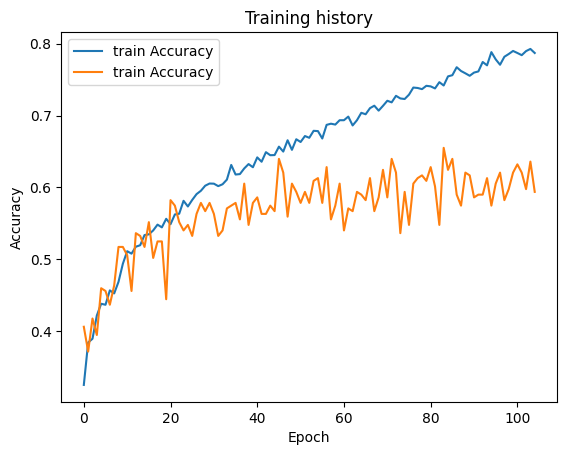

In [90]:
plt.plot(history['train_Accuracy'], label='train Accuracy')
plt.plot(history['val_Accuracy'], label='train Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


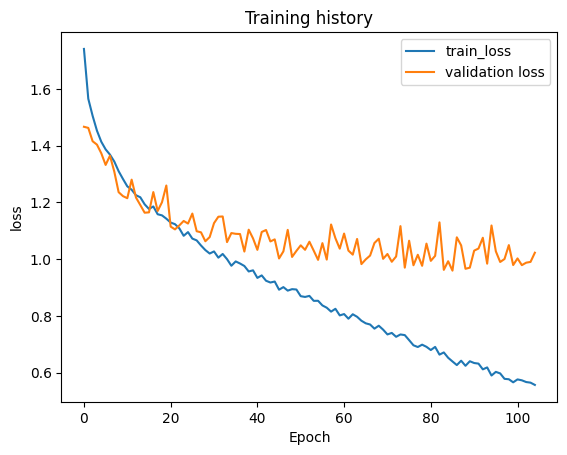

In [91]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()


In [92]:
def get_predicted(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for test_input, test_label in data_loader:
            test_label = test_label.to(device)
            test_input = test_input.to(device)

            output_logits, output_softmax = model(test_input.float())

            predictions = torch.argmax(output_softmax, dim=1)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(test_label.cpu().numpy())

            loss = loss_fn(output_logits, test_label)
            losses.append(loss.item())

    mean_loss = np.mean(losses)

    return mean_loss, predicted_labels, true_labels

In [93]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def measurements_of_accuracy(Y_test,Y_pred,classifier,labels):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
    matrix_precentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title("Confusion Matrix for "+classifier+"Classifier", fontsize=18)
    plt.grid(False)
    plt.xticks(range(len(labels)), labels, rotation=90)  # Set x-axis labels
    plt.yticks(range(len(labels)), labels)  # Set y-axis labels
    plt.show()
    
    #Accuracy
    print('Accuracy : %.4f' % accuracy_score(Y_test, Y_pred))

    #precision score
    print('Precision : %.4f' % precision_score(Y_test, Y_pred,average='macro'))
    
    #Recall Score
    print('Recall : %.4f' % recall_score(Y_test, Y_pred,average='macro'))
    
    #F1 score
    print('F1 Score : %.4f' % f1_score(Y_test, Y_pred,average='macro'))

In [95]:
label_mapping

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}

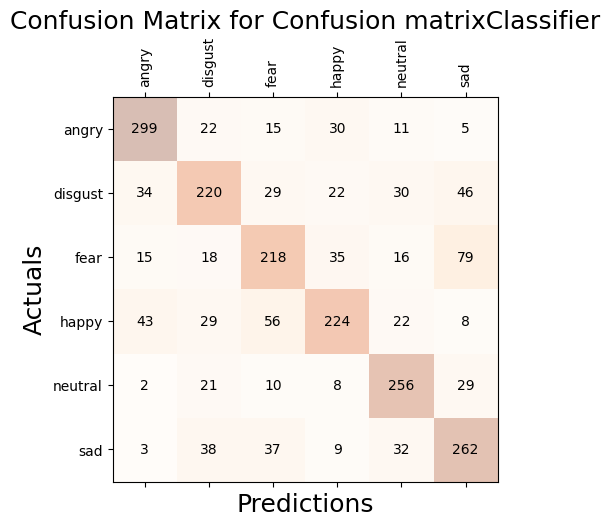

Accuracy : 0.6623
Precision : 0.6626
Recall : 0.6653
F1 Score : 0.6622


In [96]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))